In [1]:
pip install dill

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import dill
import pandas as pd
import os
import re
import json
from collections import Counter
import time

import vertexai
from vertexai.generative_models import GenerativeModel
from vertexai.preview.tuning import sft
from vertexai.preview import tuning
from google.cloud import storage

In [3]:
DIR = 'trajectories_train'
BUCKET = 'trajectory-datasets'

project_id = "neon-bank-425302-s5"
vertexai.init(project=project_id, location="us-central1")
model = GenerativeModel(model_name="gemini-1.0-pro-002")
client = storage.Client(project=project_id)
bucket = client.get_bucket(BUCKET)
source_model="gemini-1.0-pro-002"

In [4]:
ENVS = {'click-checkboxes-soft':10,
 'click-tab-2-hard':20,
 'social-media':15,
 'email-inbox':30,
 'social-media-some':30,
 'tic-tac-toe':10,
 'use-autocomplete':10,
 'book-flight':30,
 'choose-date':20,
 'search-engine':20}

In [32]:
def remove_nonessentials(dom):
    elements = []
    for e in dom:
        element = e.copy()
        del element['fg_color']
        del element['bg_color']
        del element['flags']
        element['left'] = int(element['left'][0])
        element['top'] = int(element['top'][0])
        element['height'] = int(element['height'][0])
        element['width'] = int(element['width'][0])
        elements.append(element)
    return elements

def rgba_to_hex_color(rgba):
    r, g, b, a = rgba
    r = round(r * 255)
    g = round(g * 255)
    b = round(b * 255)
    hex_color = f'#{r:02x}{g:02x}{b:02x}'
    return hex_color

def remove_nonessentials_sms(dom):
    elements = []
    for e in dom:
        element = e.copy()
        element['fg_color'] = rgba_to_hex_color(element['fg_color'])
        element['bg_color'] = rgba_to_hex_color(element['bg_color'])
        element['flags'] = element['flags'].astype(int)
        element['left'] = int(element['left'][0])
        element['top'] = int(element['top'][0])
        element['height'] = int(element['height'][0])
        element['width'] = int(element['width'][0])
        elements.append(element)
    return elements
def remove_nonessentials_sms(dom):
    elements = []
    for e in dom:
        element = e.copy()
        del element['fg_color']
        del element['bg_color']
        element['flags'] = element['flags'].astype(int)
        element['left'] = int(element['left'][0])
        element['top'] = int(element['top'][0])
        element['height'] = int(element['height'][0])
        element['width'] = int(element['width'][0])
        elements.append(element)
    return elements
def get_lengths(trajectory, env):
    states = trajectory['states']
    doms = [x['dom_elements'] for x in states]
    images = [x['screenshot'] for x in states]
    actions = [x['action'] for x in states]
    goals = [trajectory['utterance']]* (len(states)-1)
    df_ref = pd.DataFrame()
    df_ref['goal'] = goals
    df_ref['dom'] = [[x.copy() for x in dom] for dom in doms][:-1]
    #df_ref['dom'] = doms[:-1]
    if env == 'social-media-some':
        df_ref['dom_simplified'] = df_ref['dom'].copy().apply(remove_nonessentials_sms)
    else:
        df_ref['dom_simplified'] = df_ref['dom'].copy().apply(remove_nonessentials)

    #df_ref['image'] = images[:-1] ## used only for verification
    df_ref['output'] = actions[1:]
    df_train = pd.DataFrame()
    df_train['input'] = df_ref.apply(lambda x: 'Goal: {} DOM elements: {}'.format(x['goal'], x['dom']), axis=1)
    df_train['input_simplified'] = df_ref.apply(lambda x: 'Goal: {} DOM elements: {}'.format(x['goal'], x['dom_simplified']).replace(
        ', dtype=float32)','').replace(', dtype=int8)','').replace('array(','').replace("'",""), axis=1)
    df_train['output'] = df_ref['output']
    lst_full, lst_short = [],[]
    max_content_full, max_content_short = 0, 0
    for row in df_train.itertuples():
        content_full = row[1]
        content_short = row[2]
        max_content_full = max(max_content_full, model.count_tokens(content_full).total_tokens)
        max_content_short = max(max_content_short, model.count_tokens(content_short).total_tokens)
        lst_full.append(json.dumps({"messages":[{"role":"user","content":row[1]},{"role":"model","content":row[3]}]}))
        lst_short.append(json.dumps({"messages":[{"role":"user","content":row[2]},{"role":"model","content":row[3]}]}))
    n_steps = len(df_train)
    longest_full, longest_short = 0,0
    total_tokens_full, total_tokens_short = 0,0
    for i in range(n_steps):
        tokens_full = model.count_tokens(lst_full[i]).total_tokens
        tokens_short = model.count_tokens(lst_short[i]).total_tokens
        total_tokens_full += tokens_full
        total_tokens_short += tokens_short
        longest_full = max(longest_full, tokens_full)
        longest_short = max(longest_short, tokens_short)
    return longest_full, longest_short ,max_content_full, max_content_short, total_tokens_full, total_tokens_short, n_steps

def get_stats(env_name):  
    files = os.listdir(DIR+'/'+env_name)
    total_files = 0
    d_list = []
    for file in files:
        if env_name not in file:
            continue
        total_files += 1
        filename = '{}/{}/{}'.format(DIR,env_name,file)
        trajectory = dill.load(open(filename,'rb'))
        if trajectory['reward'] <= 0:
            continue
        longest_full, longest_short ,max_content_full, max_content_short, total_tokens_full, total_tokens_short, n_steps = get_lengths(trajectory,env_name)
        d_list.append({'env_name':env_name, 'filename': filename,'goal':trajectory['utterance']
                      ,'reward':trajectory['reward']
                      ,'n_steps': n_steps
                      ,'max_tokens_ex_full':longest_full
                       ,'max_tokens_ex_short':longest_short
                       ,'max_tokens_cn_full':max_content_full
                       ,'max_tokens_cn_short':max_content_short
                      ,'total_tokens_full':total_tokens_full
                      ,'total_tokens_short':total_tokens_short})
    stats = [{'env_name':env_name, 'trajectories':total_files,'rewards':len(d_list),'pct_reward':len(d_list)/total_files}]
    return pd.DataFrame(d_list),pd.DataFrame(stats)

In [81]:
def run_dataset_analysis():
    df_token_counts = pd.DataFrame()
    df_env_summary = pd.DataFrame()
    for environment in ENVS:
        print(environment)
        df1, df2 = get_stats(environment)
        df_token_counts = pd.concat([df_token_counts,df1])
        df_env_summary = pd.concat([df_env_summary,df2])
        print(df_env_summary)
    return df_token_counts, df_env_summary
df_token_counts, df_env_summary = run_dataset_analysis()

click-checkboxes-soft
                env_name  trajectories  rewards  pct_reward
0  click-checkboxes-soft           100      100         1.0
click-tab-2-hard
                env_name  trajectories  rewards  pct_reward
0  click-checkboxes-soft           100      100         1.0
0       click-tab-2-hard           100      100         1.0
social-media
                env_name  trajectories  rewards  pct_reward
0  click-checkboxes-soft           100      100    1.000000
0       click-tab-2-hard           100      100    1.000000
0           social-media           265      221    0.833962
email-inbox
                env_name  trajectories  rewards  pct_reward
0  click-checkboxes-soft           100      100    1.000000
0       click-tab-2-hard           100      100    1.000000
0           social-media           265      221    0.833962
0            email-inbox           108      108    1.000000
social-media-some
                env_name  trajectories  rewards  pct_reward
0  click-checkboxe

<Axes: >

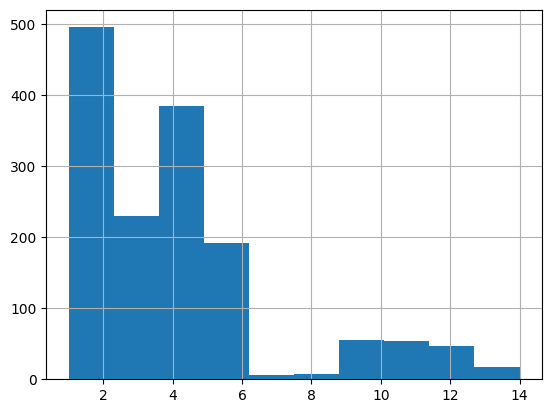

In [84]:
df_token_counts.n_steps.hist()

<Axes: >

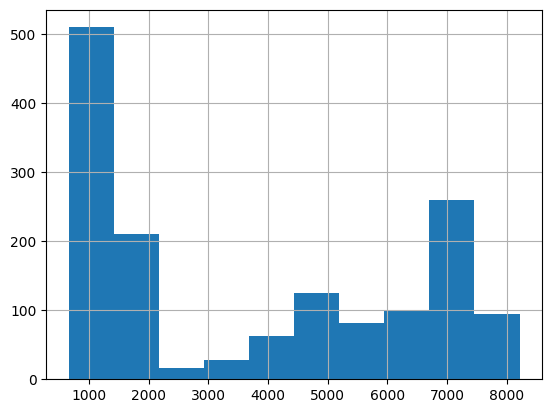

In [85]:
df_token_counts.max_tokens_cn_short.hist()

<Axes: >

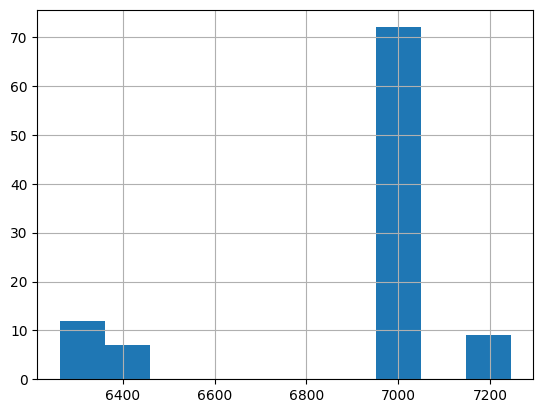

In [86]:
df_token_counts[df_token_counts.env_name=='choose-date'].max_tokens_cn_short.hist()

<Axes: >

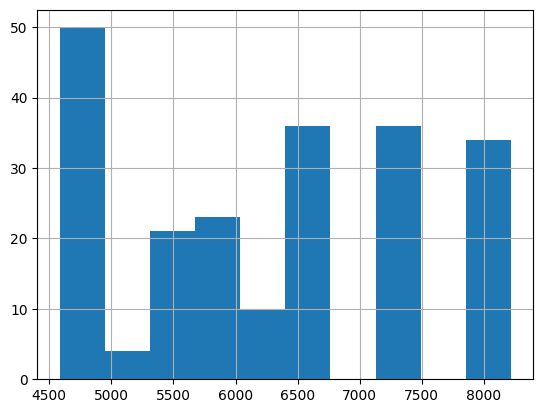

In [87]:
df_token_counts[df_token_counts.env_name=='social-media-some'].max_tokens_cn_short.hist()

In [88]:
df_env_summary

,env_name,trajectories,rewards,pct_reward
0,click-checkboxes-soft,100,100,1.000000
0,click-tab-2-hard,100,100,1.000000
0,social-media,265,221,0.833962
0,email-inbox,108,108,1.000000
0,social-media-some,216,214,0.990741
0,tic-tac-toe,323,200,0.619195
0,use-autocomplete,209,203,0.971292
0,book-flight,199,121,0.608040
0,choose-date,100,100,1.000000
0,search-engine,132,120,0.909091


In [95]:
df_token_counts[df_token_counts.env_name=='tic-tac-toe']

,env_name,filename,goal,reward,n_steps,max_tokens_ex_full,max_tokens_ex_short,max_tokens_cn_full,max_tokens_cn_short,total_tokens_full,total_tokens_short
0,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe036.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8200,4,2637,932,2570,865,10470,3662
1,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe254.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8137,4,2641,935,2574,868,10487,3675
2,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe172.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8719,3,2628,925,2562,859,7833,2730
3,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe270.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8132,4,2637,932,2570,865,10471,3663
4,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe059.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8732,3,2633,929,2566,862,7846,2740
...,...,...,...,...,...,...,...,...,...,...,...
195,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe199.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8634,3,2628,925,2562,859,7833,2730
196,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe041.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8740,3,2629,926,2562,859,7834,2731
197,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe016.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8073,4,2637,932,2570,865,10470,3662
198,tic-tac-toe,trajectories_train/tic-tac-toe/tic-tac-toe018.pkd,"Playing as 'X', win a game of tic-tac-toe.",0.8681,3,2628,925,2562,859,7833,2730


In [90]:
df_token_counts[df_token_counts.max_tokens_cn_short>8192].groupby('env_name').agg('count')

,filename,goal,reward,n_steps,max_tokens_ex_full,max_tokens_ex_short,max_tokens_cn_full,max_tokens_cn_short,total_tokens_full,total_tokens_short
env_name,,,,,,,,,,
social-media-some,21,21,21,21,21,21,21,21,21,21


In [91]:
df_token_counts[df_token_counts.max_tokens_cn_short<=8192].groupby('env_name').agg('count')

,filename,goal,reward,n_steps,max_tokens_ex_full,max_tokens_ex_short,max_tokens_cn_full,max_tokens_cn_short,total_tokens_full,total_tokens_short
env_name,,,,,,,,,,
book-flight,121,121,121,121,121,121,121,121,121,121
choose-date,100,100,100,100,100,100,100,100,100,100
click-checkboxes-soft,100,100,100,100,100,100,100,100,100,100
click-tab-2-hard,100,100,100,100,100,100,100,100,100,100
email-inbox,108,108,108,108,108,108,108,108,108,108
search-engine,120,120,120,120,120,120,120,120,120,120
social-media,221,221,221,221,221,221,221,221,221,221
social-media-some,193,193,193,193,193,193,193,193,193,193
tic-tac-toe,200,200,200,200,200,200,200,200,200,200


In [93]:
def remove_duplicates(df_token_counts):
    for env in [x for x in ENVS if x != 'tic-tac-toe']:
        print(env)
        training_prompts = df_token_counts[df_token_counts.env_name == env].goal.values
        repeats = [x[0] for x in Counter(training_prompts).items() if x[1]>1]
        for goal in repeats:
            filenames = df_token_counts[(df_token_counts.env_name == env) & (df_token_counts.goal == goal)].filename.values
            trajectories = []
            for filename in filenames:
                trajectory = dill.load(open(filename,'rb'))
                actions = []
                for state in trajectory['states']:
                    actions.append(state['action'])
                trajectories.append(actions)
            lengths = [len(x) for x in trajectories]
            ## only supports two equal trajectories
            if len(set(lengths)) == 1:
                if trajectories[0] ==  trajectories[1]:
                    print('two trajectories are the same',filenames)
                    print('deleting duplicate trajectory for environment {}'.format(env))
                    print(filenames[1])
                    df_token_counts = df_token_counts[df_token_counts.filename != filenames[1]]
    return df_token_counts
df_token_counts=remove_duplicates(df_token_counts)
df_token_counts

click-checkboxes-soft
click-tab-2-hard
social-media
two trajectories are the same ['trajectories_train/social-media/social-media100.pkd'
 'trajectories_train/social-media/social-media037.pkd']
deleting duplicate trajectory for environment social-media
trajectories_train/social-media/social-media037.pkd
email-inbox
social-media-some
use-autocomplete
two trajectories are the same ['trajectories_train/use-autocomplete/use-autocomplete117.pkd'
 'trajectories_train/use-autocomplete/use-autocomplete029.pkd']
deleting duplicate trajectory for environment use-autocomplete
trajectories_train/use-autocomplete/use-autocomplete029.pkd
two trajectories are the same ['trajectories_train/use-autocomplete/use-autocomplete051.pkd'
 'trajectories_train/use-autocomplete/use-autocomplete173.pkd']
deleting duplicate trajectory for environment use-autocomplete
trajectories_train/use-autocomplete/use-autocomplete173.pkd
two trajectories are the same ['trajectories_train/use-autocomplete/use-autocomplete012.p

,env_name,filename,goal,reward,n_steps,max_tokens_ex_full,max_tokens_ex_short,max_tokens_cn_full,max_tokens_cn_short,total_tokens_full,total_tokens_short
0,click-checkboxes-soft,trajectories_train/click-checkboxes-soft/click...,"Select words similar to vermillion, flame, bun...",0.03490,5,3446,1134,3404,1091,17206,5651
1,click-checkboxes-soft,trajectories_train/click-checkboxes-soft/click...,Select words similar to fleshy and click Submit.,0.66930,2,3419,1118,3379,1077,6838,2235
2,click-checkboxes-soft,trajectories_train/click-checkboxes-soft/click...,"Select words similar to TV, corrupt, chop and ...",0.20560,3,2930,961,2890,921,8785,2881
3,click-checkboxes-soft,trajectories_train/click-checkboxes-soft/click...,"Select words similar to pig, scared and click ...",0.47610,3,3932,1289,3892,1249,11788,3862
4,click-checkboxes-soft,trajectories_train/click-checkboxes-soft/click...,"Select words similar to tiny, adore, end, laug...",0.05460,5,3940,1298,3898,1255,19676,6471
...,...,...,...,...,...,...,...,...,...,...,...
114,search-engine,trajectories_train/search-engine/search-engine...,"Use the textbox to enter ""Dannie"" and press ""S...",0.84215,6,5440,1800,5382,1742,18893,6319
115,search-engine,trajectories_train/search-engine/search-engine...,"Use the textbox to enter ""Jerald"" and press ""S...",0.84415,6,5441,1798,5383,1740,18882,6313
116,search-engine,trajectories_train/search-engine/search-engine...,"Use the textbox to enter ""Kanesha"" and press ""...",0.90365,4,5048,1677,4998,1627,8393,2849
117,search-engine,trajectories_train/search-engine/search-engine...,"Use the textbox to enter ""Jerald"" and press ""S...",0.90170,4,5042,1662,4992,1612,8387,2834


In [96]:
dill.dump(df_token_counts,open('training_stats.pkd','wb'))

### Functions to create json dataset

In [97]:
def create_jsonl(trajectory,env):
    states = trajectory['states']
    doms = [x['dom_elements'] for x in states]
    images = [x['screenshot'] for x in states]
    actions = [x['action'] for x in states]
    goals = [trajectory['utterance']]* (len(states)-1)
    df_ref = pd.DataFrame()
    df_ref['goal'] = goals
    df_ref['dom'] =doms[:-1]
    if env == 'social-media-some':
        df_ref['dom_simplified'] = df_ref['dom'].copy().apply(remove_nonessentials_sms)
    else:
        df_ref['dom_simplified'] = df_ref['dom'].copy().apply(remove_nonessentials)

    df_ref['output'] = actions[1:]
    df_train = pd.DataFrame()
    df_train['input'] = df_ref.apply(lambda x: 'Goal: {} DOM elements: {}'.format(x['goal'], x['dom']).replace(
        ', dtype=float32)','').replace(', dtype=int8)','').replace('array(','').replace("'",""), axis=1)
    df_train['output'] = df_ref['output']
    lst = []
    for row in df_train.itertuples():
        lst.append(json.dumps({"messages":[{"role":"user","content":row[1]},{"role":"model","content":row[2]}]}))
    return lst

def create_test_dataset(env,df_stats):
    jsonl = []
    filenames = df_token_counts[(df_stats.env_name == env) & (df_stats.max_tokens_cn_short<=8192)].filename.values
    for filename in filenames:
        trajectory = dill.load(open(filename,'rb'))
        jsonl += create_jsonl(trajectory,env)
    dataset_name ='dataset_{}.JSONL'.format(env)
    print(dataset_name,len(jsonl))
    with open(dataset_name, 'w') as file:
        for example in jsonl:
            file.write(example + '\n')
    source_file_name = dataset_name
    blob = bucket.blob(dataset_name)
    blob.upload_from_filename(dataset_name)
    return dataset_name,len(jsonl)

def concatenate_jsonl_files(input_files, output_file):
    count_examples = 0
    with open(output_file, 'w') as outfile:
        for file_path in input_files:
            with open(file_path, 'r') as infile:
                for line in infile:
                    outfile.write(line)
                    count_examples +=1
    print('Total examples: {}', count_examples)
    source_file_name = output_file
    blob = bucket.blob(output_file)
    blob.upload_from_filename(output_file)

### Train function

In [98]:
def train(source_model, train_dataset, tuned_model_display_name):
    sft_tuning_job = sft.train(
        source_model=source_model,
        train_dataset=train_dataset,
        epochs=4,
        learning_rate_multiplier=1.0,
        tuned_model_display_name=tuned_model_display_name)
    # Polling for job completion
    while not sft_tuning_job.has_ended:
        time.sleep(60)
        sft_tuning_job.refresh()

    print(sft_tuning_job.tuned_model_name)
    print(sft_tuning_job.tuned_model_endpoint_name)
    print(sft_tuning_job.experiment)

### Train final model with all environments

In [99]:
input_files = []
lengths = []
for env in ENVS:
    dataset_name,length = create_test_dataset(env, df_token_counts)
    input_files.append(dataset_name)
    lengths.append(length)
    
df = pd.DataFrame()
df['Environment'] = ENVS.keys()
df = df.set_index('Environment')
df['Number of Trajectories'] = df_token_counts[df_token_counts.max_tokens_cn_short<=8192].groupby('env_name').agg('count').filename
df['Number of Examples'] = lengths
df.to_csv('dataset_composition2.csv')
concatenate_jsonl_files(input_files, 'dataset_full1.JSONL' )
df

dataset_click-checkboxes-soft.JSONL 323
dataset_click-tab-2-hard.JSONL 263
dataset_social-media.JSONL 345
dataset_email-inbox.JSONL 280
dataset_social-media-some.JSONL 524
dataset_tic-tac-toe.JSONL 681
dataset_use-autocomplete.JSONL 784
dataset_book-flight.JSONL 1336
dataset_choose-date.JSONL 838
dataset_search-engine.JSONL 560
Total examples: {} 5934


,Number of Trajectories,Number of Examples
Environment,,
click-checkboxes-soft,100,323
click-tab-2-hard,100,263
social-media,220,345
email-inbox,108,280
social-media-some,193,524
tic-tac-toe,200,681
use-autocomplete,196,784
book-flight,121,1336
choose-date,100,838


In [ ]:

train_dataset="gs://trajectory-datasets/dataset_full1.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_full1"
train(source_model, train_dataset, tuned_model_display_name)
df

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/2650224653921943552
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/2650224653921943552')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/2650224653921943552?project=829542692869


### Train only with choose-date to incorporate more specific date navigating instructions

In [62]:
print(create_test_dataset('choose-date',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_choose-date.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_choose-date3"
train(source_model, train_dataset, tuned_model_display_name)

dataset_choose-date.JSONL 838
dataset_choose-date.JSONL
Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/2480319321104973824
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/2480319321104973824')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/2480319321104973824?project=829542692869


projects/829542692869/locations/us-central1/models/3351813918275141632@1
projects/829542692869/locations/us-central1/endpoints/4076731830072508416


### Train only with improved social media some incorporating color and fixed first,second... narration

In [ ]:
print(create_test_dataset('social-media-some',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_social-media-some.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_social-media-some2"
train(source_model, train_dataset, tuned_model_display_name)

### Train with all environments

In [80]:
input_files = []
for env in ENVS:
    dataset_name = create_test_dataset(env, df_token_counts)
    input_files.append(dataset_name)
    
concatenate_jsonl_files(input_files, 'dataset_full.JSONL' )

dataset_click-checkboxes-soft.JSONL 323
dataset_click-tab-2-hard.JSONL 263
dataset_social-media.JSONL 163
dataset_email-inbox.JSONL 280
dataset_social-media-some.JSONL 272
dataset_tic-tac-toe.JSONL 340
dataset_use-autocomplete.JSONL 404
dataset_book-flight.JSONL 1234
dataset_choose-date.JSONL 871
dataset_search-engine.JSONL 459
Total examples: {} 4609


In [ ]:
train_dataset="gs://trajectory-datasets/dataset_full.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_full"
train(source_model, train_dataset, tuned_model_display_name)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/501717360596484096
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/501717360596484096')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/501717360596484096?project=829542692869


projects/829542692869/locations/us-central1/models/7050368723974094848@1
projects/829542692869/locations/us-central1/endpoints/4819825768588640256


### Train only with dataset social-media-some, improved with first, second.. narration

In [ ]:
print(create_test_dataset('social-media-some',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_social-media-some.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_social-media-some1"
train(source_model, train_dataset, tuned_model_display_name)

### Train only with improved dataset click-checkboxes-soft, now fixed

In [66]:
print(create_test_dataset('click-checkboxes-soft',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_click-checkboxes-soft.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_click-checkboxes-soft"
train(source_model, train_dataset, tuned_model_display_name)

dataset_click-checkboxes-soft.JSONL 323
dataset_click-checkboxes-soft.JSONL
Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/9151830423007920128
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/9151830423007920128')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/9151830423007920128?project=829542692869


projects/829542692869/locations/us-central1/models/5273135721023012864@1
projects/829542692869/locations/us-central1/endpoints/6441121634442018816


### Train only with dataset choose-date modified to explain last step better

In [ ]:
print(create_test_dataset('choose-date',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_choose-date.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_choose-date2"
train(source_model, train_dataset, tuned_model_display_name)

dataset_search-engine.JSONL 459
dataset_search-engine.JSONL
Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/561302094728921088
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/561302094728921088')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/561302094728921088?project=829542692869


projects/829542692869/locations/us-central1/models/5955431064569643008@1
projects/829542692869/locations/us-central1/endpoints/8500955514010599424


### Train only with dataset book-flight, improved for date picking narration

In [ ]:
print(create_test_dataset('book-flight',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_book-flight.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_book-flight1"
train(source_model, train_dataset, tuned_model_display_name)

dataset_book-flight.JSONL 1234
dataset_book-flight.JSONL
Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/5385290614340321280
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/5385290614340321280')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/5385290614340321280?project=829542692869


projects/829542692869/locations/us-central1/models/1822815456503791616@1
projects/829542692869/locations/us-central1/endpoints/6917940244989870080


### Train only with dataset search-engine

In [24]:
print(create_test_dataset('search-engine',df_token_counts))
train_dataset="gs://trajectory-datasets/dataset_search-engine.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_search-engine"
train(source_model, train_dataset, tuned_model_display_name)

dataset_search-engine.JSONL 459
dataset_search-engine.JSONL
Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/2449189947899379712
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/2449189947899379712')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/2449189947899379712?project=829542692869


projects/829542692869/locations/us-central1/models/278080784315711488@1
projects/829542692869/locations/us-central1/endpoints/5355191174292307968


### Train only with dataset choose-date

In [10]:
train_dataset="gs://trajectory-datasets/dataset_choose-date.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_choose-date"
train(source_model, train_dataset, tuned_model_display_name)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/3875634761124806656
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/3875634761124806656')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3875634761124806656?project=829542692869


projects/829542692869/locations/us-central1/models/3442985422450327552@1
projects/829542692869/locations/us-central1/endpoints/8851391860015366144


### Train only with dataset book-flight

In [ ]:
train_dataset="gs://trajectory-datasets/dataset_book-flight.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_book-flight"
train(source_model, train_dataset, tuned_model_display_name)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/6449991703980933120
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/6449991703980933120')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/6449991703980933120?project=829542692869


### Train model with all environments except click-checkboxes-soft and search-engine

In [67]:
input_files = []
for env in [x for x in ENVS if x not in ['click-checkboxes-soft', 'search-engine']]:
    dataset_name = create_test_dataset(env, df_token_counts)
    input_files.append(dataset_name)
    
concatenate_jsonl_files(input_files, 'dataset_partial.JSONL' )

dataset_click-tab-2-hard.JSONL 263
dataset_social-media.JSONL 163
dataset_email-inbox.JSONL 280
dataset_social-media-some.JSONL 405
dataset_tic-tac-toe.JSONL 340
dataset_use-autocomplete.JSONL 404
dataset_book-flight.JSONL 1120
dataset_choose-date.JSONL 820
Total examples: {} 3795


In [ ]:
train_dataset="gs://trajectory-datasets/dataset_partial.JSONL"
tuned_model_display_name="tuned_gemini_pro_dataset_partial"
train(source_model, train_dataset, tuned_model_display_name)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/829542692869/locations/us-central1/tuningJobs/3725331521607827456
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/829542692869/locations/us-central1/tuningJobs/3725331521607827456')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3725331521607827456?project=829542692869


projects/829542692869/locations/us-central1/models/2055313787266793472@1
projects/829542692869/locations/us-central1/endpoints/7375337082144686080
